In [1]:
%load_ext autoreload
%autoreload 2
%cd ~/austin_big_vision
import io
import os
import jax
import json
import requests
import importlib
import numpy as np
from PIL import Image
import ml_collections
import jax.numpy as jnp
import tensorflow as tf

import big_vision.utils as u
import big_vision.models.vit as model_mod
from big_vision.models.vit import scan_to_pyloop

import nest_asyncio
nest_asyncio.apply()

/home/austinwang/austin_big_vision


2024-10-30 15:22:19.544802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 15:22:19.568778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 15:22:19.576024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 15:22:20.872505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
backbone_path = 'gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/coca_unified_s9b_bs32768_warm0.03_1.0co-1.0ca_lr1e-3_wd1e-4_bf16_qknorm-T_decoder-bias-T_capln-F_unimask-causal_b2-0.95_6lyr_masked0.0_scan-F_fsdp-F_10-06_0223'

config_path = f'{backbone_path}/config.json'
metrics_path = f'{backbone_path}/big_vision_metrics.txt'
config = ml_collections.ConfigDict(json.load(tf.io.gfile.GFile(config_path, 'r')))
bv_metrics = json.loads(tf.io.gfile.GFile(metrics_path, 'r').read().split('\n')[-2])
ckpt_path = f'{backbone_path}/checkpoint.bv-{config.total_steps:09d}'
model_cfg = config.model
img_key = 'img' if 'image' in model_cfg or 'img' in model_cfg else 'encoder'

# load model
model_mod = importlib.import_module(f"big_vision.models.{config.model_name}")
bv_model = model_mod.Model(**model_cfg)
# load ckpt weights
rng = jax.random.PRNGKey(42)

In [5]:
ckpt_path = "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/coca_unified_s9b_bs32768_warm0.03_1.0co-1.0ca_lr1e-3_wd1e-4_bf16_qknorm-T_decoder-bias-T_capln-F_unimask-causal_b2-0.95_6lyr_masked0.0_scan-F_fsdp-F_10-06_0223/checkpoint.bv-000194000-tmp/"

In [6]:
dummy_img = jnp.zeros([2, 224, 224, 3], jnp.float32)
dummy_txt = jnp.zeros([2, 64], jnp.int32)
dummy_mask_ar = jnp.zeros([2, 64], jnp.bool_) if 'llm' in model_cfg else None
if dummy_mask_ar is not None:
    init_params = jax.jit(bv_model.init, backend="cpu")(rng, dummy_img, dummy_txt,dummy_mask_ar)['params']
else:
    init_params = jax.jit(bv_model.init, backend="cpu")(rng, dummy_img, dummy_txt)['params']
# img_load_kw = {'dont_load': ('.*_ln/scale','head/kernel', 'head/bias')}
params = model_mod.load(init_params, ckpt_path, model_cfg) #, img_load_kw)
jax.tree.map(jnp.shape, params)

I1030 15:25:31.684160 1205130 google_auth_provider.cc:181] Running on GCE, using service account 373177222751-compute@developer.gserviceaccount.com
/tmp/ipykernel_1203083/3979664868.py:11: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(jnp.shape, params)


{'encoder': {'MAPHead_0': {'LayerNorm_0': {'bias': (768,), 'scale': (768,)},
   'MlpBlock_0': {'Dense_0': {'bias': (3072,), 'kernel': (768, 3072)},
    'Dense_1': {'bias': (768,), 'kernel': (3072, 768)}},
   'MultiHeadDotProductAttention_0': {'key': {'bias': (12, 64),
     'kernel': (768, 12, 64)},
    'out': {'bias': (768,), 'kernel': (12, 64, 768)},
    'query': {'bias': (12, 64), 'kernel': (768, 12, 64)},
    'value': {'bias': (12, 64), 'kernel': (768, 12, 64)}},
   'probe': (1, 196, 768)},
  'MAPHead_1': {'LayerNorm_0': {'bias': (768,), 'scale': (768,)},
   'MlpBlock_0': {'Dense_0': {'bias': (3072,), 'kernel': (768, 3072)},
    'Dense_1': {'bias': (768,), 'kernel': (3072, 768)}},
   'MultiHeadDotProductAttention_0': {'key': {'bias': (12, 64),
     'kernel': (768, 12, 64)},
    'out': {'bias': (768,), 'kernel': (12, 64, 768)},
    'query': {'bias': (12, 64), 'kernel': (768, 12, 64)},
    'value': {'bias': (12, 64), 'kernel': (768, 12, 64)}},
   'probe': (1, 1, 768)},
  'Transformer'

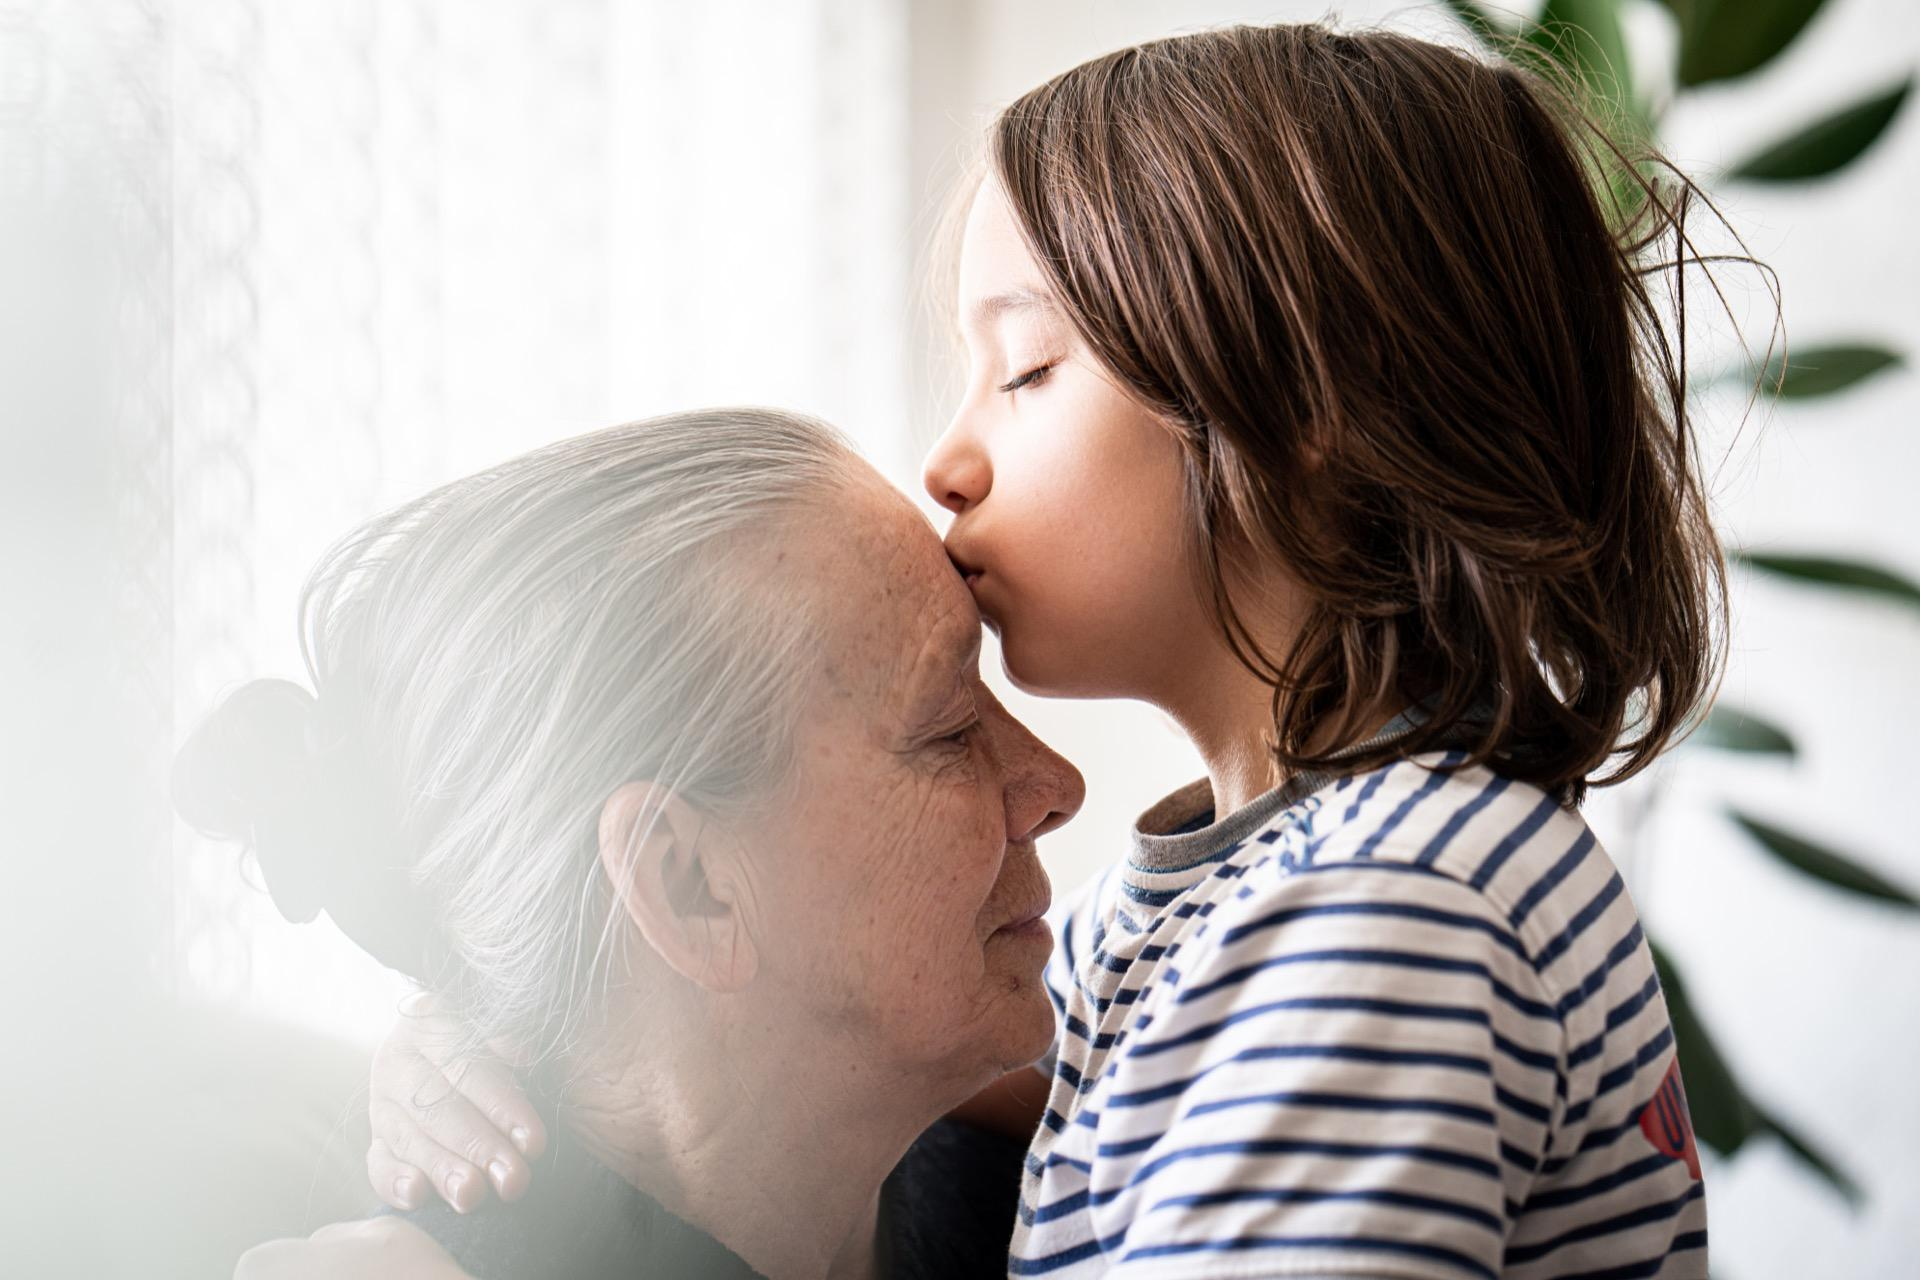

In [18]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
url = 'https://datasets-server.huggingface.co/assets/Multimodal-Fatima/winoground-image-1/--/default/test/0/image/image.jpg?Expires=1730307873&Signature=Jzqaijy6x-0kVylbenpO4gkaZ0S1reR1Pn~MESzQlleo6b-uVWWxMDuQOzJZ2GDEtaOzo437Ko1bB31cOifF8vTTIORLGApwIM5tYFFczkUoaaoA-ymxU7nZ~btPeZOpRat-FcDYJ-GjDW-O7vkzwLM-yLFORrZCNZ~4bv2-N7eMSbfdbCdH3VDJTVkhxvH-yOLSpOHDQocsWb0ZXVIPJOozVyQggqaHYrgcfV3Yv-SJddWRdXTKEYpAvapdTUiCYbEjttHAWtO0eM2swK~DeMflwlOP9Otx9L7SuNn9Ker-oaN5a-wj6Gfg115jmmrD7~oLLVht2zMyODqHV1YSew__&Key-Pair-Id=K3EI6M078Z3AC3'
image = Image.open(requests.get(url, stream=True).raw)
image

In [19]:
bv_img = jnp.array(image.resize((224, 224)))
# add a batch dimension
bv_img = jnp.expand_dims(bv_img, axis=0)
bv_out = bv_model.apply({"params":params}, bv_img, return_enc_features=True, method = 'encode')

In [20]:
out_dict = bv_out[1]
blk00_out = out_dict['encoder']['block00']['+mlp']
blk01_out = out_dict['encoder']['block01']['+mlp']
blk02_out = out_dict['encoder']['block02']['+mlp']
blk03_out = out_dict['encoder']['block03']['+mlp']
blk04_out = out_dict['encoder']['block04']['+mlp']

In [21]:
blk00_out, blk01_out, blk02_out, blk03_out, blk04_out

(Array([[[-63.25, -70, -78.5, ..., -140, -146, -95.5],
         [-61.75, -72.5, -78, ..., -140, -155, -90],
         [-65, -74.5, -81, ..., -142, -152, -96.5],
         ...,
         [-17.75, 4.125, -8.875, ..., -38.25, 16, -11.0625],
         [5.0625, -25, -48, ..., -75, -132, -53.5],
         [-66, -75, -77.5, ..., -130, -127, -75.5]]], dtype=bfloat16),
 Array([[[-64, -68.5, -78.5, ..., -139, -147, -95.5],
         [-62.5, -71.5, -78, ..., -139, -156, -90],
         [-65.5, -73, -81, ..., -141, -153, -96.5],
         ...,
         [-16.5, 1.91406, -8.9375, ..., -36.5, 16.125, -14.5],
         [5.8125, -25.5, -50, ..., -73.5, -131, -54.5],
         [-66.5, -74.5, -78, ..., -129, -128, -75.5]]], dtype=bfloat16),
 Array([[[-63.5, -67.5, -78, ..., -139, -145, -95],
         [-61.75, -70.5, -77.5, ..., -139, -154, -90],
         [-65, -72, -80.5, ..., -141, -151, -96],
         ...,
         [-16.375, 1.40625, -8.5625, ..., -35.5, 16.875, -14.75],
         [6.0625, -25.75, -49.75, ..., -7

In [22]:
# bv_out[0].shape,
jax.tree.map(lambda x: (x.mean().item(),x.std().item()), bv_out[1])

{'captioning_zimg': (-0.04931640625, 0.828125),
 'contrastive_zimg': (-0.5078125, 1.3828125),
 'encoded': (-0.015691177919507027, 0.9758082628250122),
 'encoder': {'block00': {'+mlp': (-64.5, 57.25),
   '+sa': (-64.5, 57.25),
   'drop_path_rate': (0.0, 0.0),
   'mlp': (-0.0220947265625, 4.0),
   'mlp_drop_path': (-0.0220947265625, 4.0),
   'sa': (0.0089111328125, 0.451171875),
   'sa_drop_path': (0.0089111328125, 0.451171875)},
  'block01': {'+mlp': (-64.5, 56.75),
   '+sa': (-64.5, 57.0),
   'drop_path_rate': (0.0, 0.0),
   'mlp': (0.0194091796875, 1.46875),
   'mlp_drop_path': (0.0194091796875, 1.46875),
   'sa': (-0.00238037109375, 0.625),
   'sa_drop_path': (-0.00238037109375, 0.625)},
  'block02': {'+mlp': (-64.5, 56.25),
   '+sa': (-64.5, 56.5),
   'drop_path_rate': (0.0, 0.0),
   'mlp': (-0.00830078125, 1.1640625),
   'mlp_drop_path': (-0.00830078125, 1.1640625),
   'sa': (-0.004913330078125, 0.640625),
   'sa_drop_path': (-0.004913330078125, 0.640625)},
  'block03': {'+mlp': (-